In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding, Bidirectional
import pandas as pd
import numpy as np
from keras.layers import LSTM
from keras.layers import TimeDistributed, Activation, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

In [ ]:
# Read Train Data - Judgement
import json
 
with open('/content/sample_data/NER_TRAIN_JUDGEMENT.json', 'r') as f:
    data_judgement = json.load(f)

In [ ]:
data_judgement[0]

{'id': '90d9a97c7b7749ec8a4f460fda6f937e',
 'annotations': [{'result': [{'value': {'start': 90,
      'end': 103,
      'text': 'Hongkong Bank',
      'labels': ['ORG']},
     'id': 'C8HPTIM1',
     'from_name': 'label',
     'to_name': 'text',
     'type': 'labels'},
    {'value': {'start': 267,
      'end': 278,
      'text': 'Rahul & Co.',
      'labels': ['ORG']},
     'id': 'KOWE3RAM',
     'from_name': 'label',
     'to_name': 'text',
     'type': 'labels'}]}],
 'data': {'text': "\n\n(7) On specific query by the Bench about an entry of Rs. 1,31,37,500 on deposit side of Hongkong Bank account of which a photo copy is appearing at p. 40 of assessee's paper book, learned authorised representative submitted that it was related to loan from broker, Rahul & Co. on the basis of his submission a necessary mark is put by us on that photo copy."},
 'meta': {'source': 'tax_districtcourts judgement https://indiankanoon.org/doc/1556717/'}}

In [ ]:
len(data_judgement)

9435

In [ ]:
# Read Train Data - Preamble
import json

with open('/content/sample_data/NER_TRAIN_PREAMBLE.json', 'r') as f:
    data_preamble = json.load(f)

In [ ]:
len(data_preamble)

1560

In [ ]:
# Tranform Judgement Data into the required Spacy format

training_data_judgement = {'classes' : ['COURT', "PETITIONER", "RESPONDENT", "JUDGE", "LAWYER", "DATE", "ORG", "GPE", 
                              "STATUTE", "PROVISION", "PRECEDENT", "CASE_NUMBER", "WITNESS", "OTHER_PERSON"], 
                 'annotations' : []}
count = 0

for example in data_judgement:
  temp_dict = {}
  temp_dict['text'] = example['data']['text']
  temp_dict['entities'] = []
  for annotation in example['annotations']:
    for result in annotation['result']:
      start = result['value']['start']
      end = result['value']['end']
      for label in result['value']['labels']:
        temp_dict['entities'].append((start, end, label))
  if temp_dict['entities']:
    training_data_judgement['annotations'].append(temp_dict)
  else:
    count += 1
# print(training_data_judgement['annotations'][0])
print("Number of entries in judgement dataset:", len(data_judgement))
print("Number of entries with no entities", count)

print("Number of entries after removing entries with no entities: ", len(training_data_judgement['annotations']))


Number of entries in judgement dataset: 9435
Number of entries with no entities 2177
Number of entries after removing entries with no entities:  7258


In [ ]:
print(training_data_judgement["annotations"][0])

{'text': "\n\n(7) On specific query by the Bench about an entry of Rs. 1,31,37,500 on deposit side of Hongkong Bank account of which a photo copy is appearing at p. 40 of assessee's paper book, learned authorised representative submitted that it was related to loan from broker, Rahul & Co. on the basis of his submission a necessary mark is put by us on that photo copy.", 'entities': [(90, 103, 'ORG'), (267, 278, 'ORG')]}


In [ ]:
# Tranform Preamble Data into the required Spacy format

training_data_preamble = {'classes' : ['COURT', "PETITIONER", "RESPONDENT", "JUDGE", "LAWYER", "DATE", "ORG", "GPE", 
                              "STATUTE", "PROVISION", "PRECEDENT", "CASE_NUMBER", "WITNESS", "OTHER_PERSON"], 
                 'annotations' : []}
count = 0

for example in data_preamble:
  temp_dict = {}
  temp_dict['text'] = example['data']['text']
  temp_dict['entities'] = []
  for annotation in example['annotations']:
    for result in annotation['result']:
      start = result['value']['start']
      end = result['value']['end']
      for label in result['value']['labels']:
        temp_dict['entities'].append((start, end, label))
  if temp_dict['entities']:
    training_data_preamble['annotations'].append(temp_dict)
  else:
    count += 1
# print(training_data['annotations'][0])
print("Number of entries in preamble dataset:", len(data_preamble))
print("Number of entries in preamble with no entities", count)

print("Number of entries in preamble after removing entries with no entities: ", len(training_data_preamble['annotations']))

Number of entries in preamble dataset: 1560
Number of entries in preamble with no entities 2
Number of entries in preamble after removing entries with no entities:  1558


In [ ]:
print(training_data_preamble["annotations"][0])

{'text': "In The High Court Of Kerala At Ernakulam\n\nCrl Mc No. 1622 of 2006()\n\n\n1. T.R.Ajayan, S/O. O.Raman,\n                      ...  Petitioner\n\n                        Vs\n\n\n\n1. M.Ravindran,\n                       ...       Respondent\n\n2. Mrs. Nirmala Dinesh, W/O. Dinesh,\n\n                For Petitioner  :Sri.A.Kumar\n\n                For Respondent  :Smt.M.K.Pushpalatha\n\nThe Hon'ble Mr. Justice P.R.Raman\nThe Hon'ble Mr. Justice V.K.Mohanan\n\n Dated :07/01/2008\n\n O R D E R\n", 'entities': [(7, 40, 'COURT'), (73, 83, 'PETITIONER'), (171, 182, 'RESPONDENT'), (237, 251, 'RESPONDENT'), (304, 311, 'LAWYER'), (350, 365, 'LAWYER'), (391, 400, 'JUDGE'), (425, 436, 'JUDGE')]}


In [ ]:
# Train Test Split
train_entries_judgement = int(len(training_data_judgement['annotations']) * 0.8)
train_data_judgement = training_data_judgement['annotations'][:train_entries_judgement]
dev_data_judgement = training_data_judgement['annotations'][train_entries_judgement:]

print("Number of entries in Train judgement dataset:", len(train_data_judgement))
print("Number of entries in Validation judgement dataset:", len(dev_data_judgement))


train_entries_preamble = int(len(training_data_preamble['annotations']) * 0.8)
train_data_preamble = training_data_preamble['annotations'][:train_entries_preamble]
dev_data_preamble = training_data_preamble['annotations'][train_entries_preamble:]

print("Number of entries in Train preamble dataset:", len(train_data_preamble))
print("Number of entries in Validation preamble dataset:", len(dev_data_preamble))

train_data = train_data_judgement + train_data_preamble
dev_data = dev_data_judgement + dev_data_preamble

print("Number of entries in Train dataset:", len(train_data))
print("Number of entries in Validation dataset:", len(dev_data))

Number of entries in Train judgement dataset: 5806
Number of entries in Validation judgement dataset: 1452
Number of entries in Train preamble dataset: 1246
Number of entries in Validation preamble dataset: 312
Number of entries in Train dataset: 7052
Number of entries in Validation dataset: 1764


In [ ]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin()

In [ ]:
# Create DocBin File of Train Data

from spacy.util import filter_spans

for training_example  in tqdm(train_data): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        # if span is None:
        #     print("Skipping entity")
        # else:
        ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("/content/sample_data/training_data.spacy") # save the docbin object

100%|██████████| 7052/7052 [00:04<00:00, 1412.58it/s]


In [ ]:
# Create DocBin File of Dev Data

for training_example  in tqdm(dev_data): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        # if span is None:
        #     print("Skipping entity")
        # else:
        ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("/content/sample_data/dev_data.spacy") # save the docbin object

100%|██████████| 1764/1764 [00:01<00:00, 1658.18it/s]


In [ ]:
# Create config file from the base config

!python -m spacy init fill-config /content/sample_data/base_config.cfg /content/sample_data/config.cfg

✔ Auto-filled config with all values
✔ Saved config
/content/sample_data/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 16 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
# Model Training

!python -m spacy train /content/sample_data/config.cfg --output ./ --paths.train /content/sample_data/training_data.spacy --paths.dev /content/sample_data/dev_data.spacy --gpu-id 0

ℹ Saving to output directory: .
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-12-05 03:14:29,583] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-12-05 03:14:29,593] [INFO] Pipeline: ['tok2vec', 'ner']
INFO:spacy:Pipeline: ['tok2vec', 'ner']
[2022-12-05 03:14:29,597] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-12-05 03:14:29,597] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
[2022-12-05 03:14:47,820] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
INFO:spacy:Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     5

In [ ]:
judgment_text = 'Petitioner:\nShiv Shakti Coop. Housing Society, Nagpur\n\nRespondent:\nM/s. Swaraj Developers & Ors.\n\nDate Of Judgment : 17/04/2003 BENCH:\nSHIVARAJ V. PATIL & ARIJIT PASAYAT.\n\nJUDGMENT:\nJ U D G M E N T (Arising Out of S.L.P. (C) No. 19030 of 2002) WITH Civil Appeal No. 3489 [email protected] S.L.P.(C)No.19852/2002, Civil Appeal Nos.3494-98/[email protected] S.L.P.(C)Nos.22848-22852/2002, and Civil Appeal No. 3499/[email protected] S.L.P.(C) No.22009/2002] ARIJIT PASAYAT,J. \n\n Leave granted. \n\n A short but important question of law involving effect of amendment to Section 115 of the Code of Civil Procedure, 1908 (in short \'the Code\') is involved in these appeals. Since the answer to the question does not involve any factual adjudication, a brief reference thereto would suffice. \n\n By Section 12(i) of the Code of Civil Procedure (Amendment) Act, 1999 (in short \'the Amendment Act\') operative from 1.7.2002, amendments were made to Section 115 of the Code. In all these appeals, the concerned High Courts held that because of amended Section 115, the revision filed before them was not maintainable, as had an order been passed in favour of the party applying for revision, same would not have finally disposed of the suit or other proceeding. \n\n It has been contended by learned counsel for the appellants that the High Court went wrong in disposing of the revision applications as not maintainable, on several grounds. They are (i) the amended provisions do not apply to petitions which were admitted before the amendment, (ii) appeals and revisions stand on a parallel footing and are vested rights in the appellant/applicant, as the case may be, and as such the amended provisions would not have any application, and (iii) the applications for injunction and the like which form subject matter of the revisions relate to the expression \'other proceeding\' and even if the amended provisions apply disposal of the revision would have meant final dismissal of such \'other proceeding\'. \n\n With reference to Section 32(2)(i) of the Amendment Act, it is submitted that the same does not convey any meaning. The legislature always saved pending proceedings in terms of Section 6 of the General Clauses Act, 1897 (in short \'General Clauses Act\') and, therefore, proceedings which were pending before the High Court on the date of amendment are clearly outside the effect of amendment. Even if it is conceded for the sake of arguments that there is no specific provision in that regard, it is clearly a case of casus omissus. \n\n In response, learned counsel for the respondents submitted that plain meaning of provisions of a statute have to be given full effect and even a bare reading of the provisions makes it clear that the High Court\'s order is on terra firma. Whenever the legislature intended to keep the pending proceedings out of the purview of amended provisions, it was specifically so provided. Reference is made to the amendment in 1976 to the Code which in Section 97(3) of the Code of Civil Procedure (Amendment) Act, 1976 (in short \'Old Amendment Act\') saved the pending proceedings, ruling out operation of Section 6 of the General Clauses Act. \n\n In order to appreciate the rival submissions it will be necessary to take note of the provisions of Section 115 as they stood before amendment and after amendment. \n\n "Section 115 (before Amendment):\n (1) The High Court may call for the record of any case which has been decided by any Court subordinate to such High Court and in which no appeal lies thereto, and if such subordinate court appears (a) to have exercised a jurisdiction not vested in it by law, or (b) to have failed to exercise a jurisdiction so vested, or (c) to have acted in the exercise of its jurisdiction illegally or with material irregularity, the High Court may make such order in the case as it thinks fit:\nProvided that the High Court shall not, under this section, vary or reverse any order made, or any order deciding an issue, in the course of a suit or order proceeding, except where (a) the order, if it had been made in favour of the party applying for revision, would have finally disposed of the suit or other proceeding, or (b) the order, if allowed to stand, would occasion a failure of justice or cause irreparable injury to the party against whom it was made. \n\n(2) The High Court shall not, under this section, vary or reverse any decree or order against which an appeal lies either to the High Court or to any Court subordinate thereto. \n\nExplanation: In this section, the expression "Any case which has been decided: includes any order made, or any order deciding an issue, in the course of a suit or other proceeding." \n\nSection 115 (after Amendment):\n (1) The High Court may call for the record of any case which has been decided by any Court subordinate to such High Court and in which no appeal lies thereto, and if such subordinate court appears (a) to have exercised a jurisdiction not vested in it by law, or (b) to have failed to exercise a jurisdiction so vested. \n\n(c) to have acted in the exercise of its jurisdiction illegally or with material irregularity, the High Court may make such order in the case as it thinks fit:\nProvided that the High Court shall not, under this section, vary or reverse any order made, or any order deciding an issue, in the course of a suit or order proceeding, except where the order, if it had been made in favour of the party applying for revision, would have finally disposed of the suit or other proceedings. \n\n(2) The High Court shall not, under this section, vary or reverse any decree or order against which an appeal lies either to the High Court or to any Court subordinate thereto. \n\n(3) A revision shall not operate as a stay of suit or other proceeding before the Court except where such suit or other proceeding is stayed by the High Court. \n\nExplanation: In this section, the expression "any case which has been decided" includes any order made, or any order deciding the issue, in the course of a suit or other proceeding." \n\n A comparison of two provisions shows that while proviso (a) of the un-amended provision has been retained in its totality, in the amended provisions clause (b) of the proviso has been omitted. \n\n It is to be noted that prior to the amendments to the Code by the Old Amendment Act, the power of revision was wider. By the amendment, certain positive restrictions were put on the High Court\'s power to deal with revisions under Section 115. Prior to the said amendment, it was not strictly necessary that the impugned order would have the result of finally deciding the lis or the proceedings in the lower courts. In fact, the power could be exercised in any case where jurisdictional error was committed by the original court or where substantial injustice had resulted. By the Old Amendment Act, the condition of finally deciding of lis and the proceedings in the subordinate courts was introduced. The proviso which was introduced contains qualifications which are pre-requisites before exercise of power under Section 115. They were clauses (a) and (b) of the proviso. Logically, the High Court has suo motu power to revise an order where total failure of justice would have occasioned or where irreparable loss would have caused to the parties against whom it was made. These powers were retained by clause (b). Though, after 1976, the exercise of power was somewhat circumscribed, it was not totally curtailed. In other words, the High Court could even after the 1976 amendment interfere in cases where there was failure of justice or irreparable loss caused, the nature of the proceedings was substantially changed and the suo motu power of the High Court was retained. It was in the nature of power of superintendence of the High Court over the subordinate courts. Changes were related to indicating limitations in exercise of power. \n\n Even after the amendments in 1976, in 1999 and prior to the amendment in 1976, the revision power was exercisable in a case where the order or the decree, as the case may be, was not appealable. \n\n Sub-section (2) which was introduced by the Old Amendment Act and retained even after present amendment, provides that the High Court shall not interfere where the order or the decree is appealable in courts subordinate to the High Court. \n\n It is interesting to note that the Law Commission of India had recommended deletion of Section 115. In the Law Commission\'s opinion, provisions of Section 115 are analogous to provisions of Article 227 of the Constitution of India, 1950 (in short \'the Constitution\') and the litigants would not be prejudiced in any way if the entire Section is deleted. The Joint Committee of the Parliament discussed these recommendations and only thought it proper to make certain modifications in the Section. That led to amendment of Section 115 by Old Amendment Act. The deliberations of the Committee are reflected in the following words:\n "The Committee, however, feel; that, in addition to the restrictions contained in section 115, an overall restriction on the scope of applications for revision against interlocutory orders should be imposed. Having regard to the recommendations made by the Law Commission in its Fourteenth and Twenty-Seventh Reports, the Committee recommended that Section 115 of the Code should be retained subject to the modification that no revision application shall lie against an interlocutory order unless either of the following conditions is satisfied, namely:-\ni. that if the orders were made in favour of the applicant, it would finally dispose of the suit or other proceeding; or ii. that the order, if allowed to stand, is likely to occasion a failure of justice or cause in irreparable injury." \n\n First aspect that has to be considered is the respective scope of appeal and revision. It is fairly a well settled position in law that the right of appeal is a substantive right. But there is no such substantive right in making an application under Section 115. Though great emphasis was laid on certain observations in Shankar Ramchandra Abhyankar v. Krishnaji Dattatraya Bapat (AIR 1970 SC 1) to contend that appeal and revision stand on the same pedestal, it is difficult to accept the proposition. The observations in the said case are being read out of context. What was held in that case related to the exercise of power of a higher court, and in that context the nature of consideration in appeal and revision was referred to. It was never held in that case that appeal is equated to a revision. \n\n Section 115 is essentially a source of power for the High Court to supervise the subordinate courts. It does not in any way confer a right on a litigant aggrieved by any order of the subordinate court to approach the High Court for relief. The scope for making a revision under Section 115 is not linked with a substantive right. \n\nLanguage of Sections 96 and 100 of the Code which deal with appeals can be compared with Section 115 of the Code. While in the former two provisions specifically provide for right of appeal, the same is not the position vis--vis section 115. It does not speak of an application being made by a person aggrieved by an order of subordinate court. As noted above, it is a source of power of the High Court to have effective control on the functioning of the subordinate courts by exercising supervisory power. \n\n An appeal is essentially continuation of the original proceedings and the provisions applied at the time of institution of the suit are to be operative even in respect of the appeals. That is because there is a vested right in the litigant to avail the remedy of an appeal. As was observed in K. Eapen Chako v. The Provident Investment Company (P) Ltd. (AIR 1976 SC 2610) only in cases where vested rights are involved, a legislation has to be interpreted to mean as one affecting such right to be prospectively operative. The right of appeal is only by statute. It is necessary part of the procedure in an action, but "the right of entering a superior court and invoking its aid and interposition to redress the error of the courts below. It seems to this paramount right, part of the progress of the inferior tribunal." (Per Westbury See: AG vs. SILLEM 33 J.Ex 209). The appeal, strictly so called, is one in which the question is, whether the order of the Court from which the appeal is brought was right on the materials which that Court had before it" (Per Lord Devuil Ponnamal vs. Arumogam 1905 AC 390). The right of appeal, where it exists, as a matter of substance and not of procedure (Colonial Sugar Refining Company vs. Irtin 1905 AC 368). \n\nRight of appeal is statutory. Right of appeal inherits in no one. When conferred by statute it becomes a vested right. In this regard there is essential distinction between right of appeal and right of suit. Where there is inherent right in every person to file a suit and for its maintainability it requires no authority of law, appeal requires so. As was observed in The State of Kerala vs. K.M. Charia Abdulla and Co. (AIR 1965 SC 1585), the distinction between right of appeal and revision is based on differences implicit in the two expressions. An appeal is continuation of the proceedings; in effect the entire proceedings are before the appellate authority and it has power to review the evidence subject to statutory limitations prescribed. But in the case of revision, whatever powers the revisional authority may or may not have, it has no power to review the evidence, unless the statute expressly confers on it that power. It was noted by the four-Judges Bench in Hari Shankar and others vs. Rao Girdhari Lal Chowdhury (AIR 1963 SC 698) that the distinction between an appeal and a revision is a real one. A right of appeal carries with it a right of re-hearing on law as well as fact, unless the statute conferring the right of appeal limits the re-hearing in some way, as has been done in second appeals arising under the Code. The power of hearing revision is generally given to a superior Court so that it may satisfy itself that a particular case has been decided according to law. Reference was made to Section 115 of the Code to hold that the High Court\'s powers under the said provision are limited to certain particular categories of cases. The right there is confined to jurisdiction and jurisdiction alone. \n\nAs regards the field of operation of amended provision, it is to be noted that the language of amended provision is clear. \n\n It is well settled principle in law that the Court cannot read anything into a statutory provision which is plain and unambiguous. A statute is an edict of the Legislature. The language employed in a statute is the determinative factor of legislative intent. Words and phrases are symbols that stimulate mental references to referents. The object of interpreting a statute is to ascertain the intention of the Legislature enacting it. (See Institute of Chartered Accountants of India v. M/s Price Waterhouse and Anr. (AIR 1998 SC 74)) The intention of the Legislature is primarily to be gathered from the language used, which means that attention should be paid to what has been said as also to what has not been said. As a consequence, a construction which requires for its support, addition or substitution of words or which results in rejection of words as meaningless has to be avoided. As observed in Crawford v. Spooner (1846 (6) Moore PC 1), Courts, cannot aid the Legislatures\' defective phrasing of an Act, we cannot add or mend, and by construction make up deficiencies which are left there. (See The State of Gujarat and Ors. v. Dilipbhai Nathjibhai Patel and Anr. (JT 1998 (2) SC 253)). It is contrary to all rules of construction to read words into an Act unless it is absolutely necessary to do so. (See Stock v. Frank Jones (Tiptan) Ltd. (1978 1 All ER 948 (HL). Rules of interpretation do not permit Courts to do so, unless the provision as it stands is meaningless or of doubtful meaning. Courts are not entitled to read words into an Act of Parliament unless clear reason for it is to be found within the four corners of the Act itself. (Per Lord Loreburn L.C. in Vickers Sons and Maxim Ltd. v. Evans (1910) AC 445 (HL), quoted in Jamma Masjid, Mercara v. Kodimaniandra Deviah and Ors.(AIR 1962 SC 847). \n\nThe question is not what may be supposed and has been intended but what has been said. "Statutes should be construed not as theorems of Euclid". Judge Learned Hand said, "but words must be construed with some imagination of the purposes which lie behind them". (See Lenigh Valley Coal Co. v. Yensavage 218 FR 547). The view was re-iterated in Union of India and Ors. v. Filip Tiago De Gama of Vedem Vasco De Gama (AIR 1990 SC 981). \n\nIn Dr. R. Venkatchalam and Ors. etc. v. Dy. Transport Commissioner and Ors. etc. (AIR 1977 SC 842), it was observed that Courts must avoid the danger of apriori determination of the meaning of a provision based on their own pre-conceived notions of ideological structure or scheme into which the provision to be interpreted is somewhat fitted. They are not entitled to usurp legislative function under the disguise of interpretation. \n\nWhile interpreting a provision the Court only interprets the law and cannot legislate it. If a provision of law is misused and subjected to the abuse of process of law, it is for the legislature to amend, modify or repeal it, if deemed necessary. (See Commissioner of Sales Tax, M.P. v. Popular Trading Company, Ujjain (2000 (5) SCC 515). The legislative casus omissus cannot be supplied by judicial interpretative process. \n\nTwo principles of construction one relating to casus omissus and the other in regard to reading the statute as a whole appear to be well settled. Under the first principle a casus omissus cannot be supplied by the Court except in the case of clear necessity and when reason for it is found in the four corners of the statute itself but at the same time a casus omissus should not be readily inferred and for that purpose all the parts of a statute or section must be construed together and every clause of a section should be construed with reference to the context and other clauses thereof so that the construction to be put on a particular provision makes a consistent enactment of the whole statute. This would be more so if literal construction of a particular clause leads to manifestly absurd or anomalous results which could not have been intended by the Legislature. "An intention to produce an unreasonable result", said Danackwerts, L.J. in Artemiou v. Procopiou (1966 1 QB 878), "is not to be imputed to a statute if there is some other construction available". Where to apply words literally would "defeat the obvious intention of the legislation and produce a wholly unreasonable result" we must "do some violence to the words" and so achieve that obvious intention and produce a rational construction. (Per Lord Reid in Luke v. IRC (1966 AC 557) where at p. 577 he also observed: "this is not a new problem, though our standard of drafting is such that it rarely emerges". It is then true that, "when the words of a law extend not to an inconvenience rarely happening, but do to those which often happen, it is good reason not to strain the words further than they reach, by saying it is casus omissus, and that the law intended quae frequentius accidunt." "But," on the other hand,"it is no reason, when the words of a law do enough extend to an inconvenience seldom happening, that they should not extend to it as well as if it happened more frequently, because it happens but seldom" (See Fenton v. Hampton 11 Moore, P.C. 345). A casus omissus ought not to be created by interpretation, save in some case of strong necessity. Where, however, a casus omissus does really occur, either through the inadvertence of the legislature, or on the principle quod semel aut bis existit proetereunt legislatores, the rule is that the particular case, thus left unprovided for, must be disposed of according to the law as it existed before such statute - Casus omissus et oblivioni datus dispositioni communis juris relinquitur; "a casus omissus," observed Buller, J. in Jones v. Smart (1 T.R. 52), "can in no case be supplied by a court of law, for that would be to make laws." \n\nThe golden rule for construing wills, statutes, and, in fact, all written instruments has been thus stated: "The grammatical and ordinary sense of the words is to be adhered to unless that would lead to some absurdity or some repugnance or inconsistency with the rest of the instrument, in which case the grammatical and ordinary sense of the words may be modified, so as to avoid that absurdity and inconsistency, but no further" (See Grey v. Pearson 6 H.L. Cas. 61). The latter part of this "golden rule" must, however, be applied with much caution. "if," remarked Jervis, C.J., "the precise words used are plain and unambiguous in our judgment, we are bound to construe them in their ordinary sense, even though it lead, in our view of the case, to an absurdity or manifest injustice. Words may be modified or varied where their import is doubtful or obscure. But we assume the functions of legislators when we depart from the ordinary meaning of the precise words used, merely because we see, or fancy we see, an absurdity or manifest injustice from an adherence to their literal meaning" (See Abley v. Dale 11, C.B. 378). \n\nAt this juncture, it would be necessary to take note of a maxim "Ad ea quae frequentius accidunt jura adaptantur" (The laws are adapted to those cases which more frequently occur). \n\nLaws ought to be, and usually are, framed with a view to such cases as are of frequent rather than such as are of rare or accidental occurrence; or, in the language of the civil law, jus constitui oportet in his quoe ut plurimum accidunt, non quoe ex inopinato; for, neque leges neque senatusconsulta ita scribi possunt ut omnes casus qui quandoque inciderint comprehendantur, sed sufficit ea quoe plerumque accident contineri; laws cannot be so worded as to include every case which may arise, but it is sufficient if they apply to those things which most frequently happen. All legislation proceeds upon the principle of providing for the ordinary course of things, and to this principle frequent reference is to be found, in the reports, in answer to arguments, often speciously advanced, that the words of an Act cannot have a particular meaning, because in a certain contingency that meaning might work a result of which nobody would approve. In Miller v. Salomons (7 Exch. 475) it was argued that Parliament could not have intended that a Jew, before sitting in the House of Commons, must use the words "on the true faith of a Christian," prescribed in the oath of abjuration of 6 Geo. 3, c.53, because any person, refusing to take the same oath when tendered by two justices, would, under the 1 Geo. 1, st.2, c.13, be deemed to be a popish recusant, and would be liable to penalties as such; and to enforce these provisions against a Jew, it was said, would be the merest tyranny. But Baron Parke thus replied to this argument: -"If in the vast majority of possible cases in all of ordinary occurrence the law is in no degree inconsistent or unreasonable construed according to its plain words, it seems to me to be an untenable proposition, and unsupported by authority, to say that the construction may be varied in every case, because there is one possible but highly improbably one in which the law would operate with great severity, and against our own notions of justice. The utmost that can be reasonably contended is, that it should be varied in that particular case, so as to obviate that injustice no further." \n\nAppeal is the right of entering a superior Court and invoking its aid and interposition to redress the error of the court below. (per Westbury C., A.G. v. Sillem, 10 HLC 704 = 33 LJ ex.209). \n\n"Appeal", is defined in the Oxford Dictionary, volume I, page 398, as the transference of a case from an inferior to a higher Court or tribunal in the hope of reversing or modifying the decision of the former. In the Law Dictionary by Sweet, the term "appeal" is defined as a proceeding taken to rectify an erroneous decision of a Court by submitting the question to a higher Court or Court of appeal, and it is added that the term, therefore, includes, in addition to the proceedings specifically so called, the cases stated for the opinion of the Queen\'s Bench Division and the Court of Crown Cases reserved, and proceedings in error. In the Law Dictionary by Bouvier an appeal is defined as the removal of a case from a Court of inferior to one of superior jurisdiction for the purpose of obtaining a review and re-trial, and it is explained that in its technical sense it differs from a writ of error in this, that it subjects both the law and the facts to a review and re- trial, while the latter is a Common Law process which involves matter of law only for re-examination; it is added, however, that the term "appeal" is used in a comprehensive sense so as to include both what is described technically as an appeal and also the common law writ of error. As Mr. Justice Subramania Ayyar observes in Chappan v. Moidin, 22 Mad 68 at p.80 the two things which are required to constitute appellate jurisdiction are the existence of the relation of superior and inferior Court and the power, on the part of the former, to review decisions of the latter. \n\n Sub-section (2) of Section 115 has remained unaltered even after the amendment by the Amendment Act. A new sub- section (3) has been added in Section 115 by the Amendment Act which states that revision shall not operate as a stay of suit or other proceeding before the Court except where such suit or other proceeding is stayed by the High Court. \n\n In Section 2, the expressions \'decree\' and \'order\' have been defined in clauses (2) and (14) respectively. It is to be noted that it matters little that the judgment is styled as an "order". If, in fact, it fulfils the conditions of the definition under Section 2(2), it is a decree and becomes appealable. Orders that are not appealable are, generally speaking, those which are procussual i.e. interlocutory or incidental orders regulating proceedings but not deciding any of the matters of controversy in the suit. Order 43 deals with the "appeals from orders". These appeals lie under Section 104 of the Code. The said Section deals with appeals from orders and specifies the orders from which appeals can lie. Sub-section (2) of Section 104 says that no appeal shall lie from any order passed in appeal under the said Section. Section 104 and Order 43 Rule I contain a full list of appealable orders. An order which amounts to a decree within Section 2(2) does not fall within Section 104 and the only applicable section is Section 96. Clauses (a) to (f) of Section 104 were omitted by Arbitration Act 1940. Section 105 relates to other orders. It, inter alia, relates to any order i.e. so appealable as well as non-appelable orders. It is in the nature of a prohibition stipulating that save as otherwise expressly provided, no appeal shall lie from any order made by a Court in exercise of original or appellate jurisdiction; but where a decree is appealed from, any error, defect or irregularity in any order, affecting the decision of the case, may be set forth as a ground of objection in the memorandum of appeal. Sub-section (2) deals with case of remand. This section, in fact, contemplates two things i.e. (1) regular appeal from decree; and (2) the provision relating to grant of objection relating to interim order. Order 43 Rule 1 is an integral part of Section 104. \n\nA plain reading of Section 115 as it stands makes it clear that the stress is on the question whether the order in favour of the party applying for revision would have given finality to suit or other proceeding. If the answer is \'yes\' then the revision is maintainable. But on the contrary, if the answer is \'no\' then the revision is not maintainable. Therefore, if the impugned order is of interim in nature or does not finally decide the lis, the revision will not be maintainable. The legislative intent is crystal clear. Those orders, which are interim in nature, cannot be the subject matter of revision under Section 115. There is marked distinction in language of Section 97(3) of the Old Amendment Act and Section 32(2)(i) of the Amendment Act. While in the former, there was clear legislative intent to save applications admitted or pending before the amendment came into force. Such an intent is significantly absent in Section 32(2)(i). The amendment relates to procedures. No person has a vested right in a course of procedure. He has only the right of proceeding in the manner prescribed. If by a statutory change the mode of procedure is altered the parties are to proceed according to the altered mode, without exception, unless there is a different stipulation. \n\n Section 6 of the General Clauses Act has no application because there is no substantive vested right available to a party seeking revision under Section 115 of the Code. In Kolhapur Canesugar Works Ltd. and another vs. Union of India and others (AIR 2000 SC 811), it was observed that if a provision of statute is unconditionally omitted without a saving clause in favour of pending proceedings, all actions must stop where the omission finds them, and if final relief has not been granted before the omission goes into effect, there is no scope for granting it afterwards. There is modification of this position by application of Section 6 of the General Clauses Act or by making special provisions. Operation of repeal or deletion as to the future and the past largely depends on the savings applicable. In a case where a particular provision in the statute is omitted and in its place another provision dealing with the same contingency is introduced without a saving clause in favour of pending proceedings, then it can be reasonably inferred that the intention of the legislature is that the pending proceedings shall continue but a fresh proceeding for the same purpose may be initiated under the new provision. \n\n In view of what has been stated above the inevitable conclusion is that the High Courts were right in the conclusion about non-maintainability of revision applications. \n\n It was submitted by learned counsel for the appellants that even if the revision applications are held to be not maintainable, there should not be a bar on challenge being made under Section 227 of the Constitution. It was submitted that an opportunity may be granted to the appellants to avail the remedy. \n\n If any remedy is available to a party under any statute no liberty is necessary to be granted for availing the same. If the appellants avail such remedy, the same shall be dealt with in accordance with law. \n\n The appeals are dismissed. No costs.'

In [ ]:
# Perform preliminary tests on a sample text using the trained model(best)

nlp_ner = spacy.load("model-best")
doc = nlp_ner(judgment_text)
colors = {'COURT': "#bbabf2", 'PETITIONER': "#f570ea", "RESPONDENT": "#cdee81", 'JUDGE': "#fdd8a5",
              "LAWYER": "#f9d380", 'WITNESS': "violet", "STATUTE": "#faea99", "PROVISION": "yellow",
              'CASE_NUMBER': "#fbb1cf", "PRECEDENT": "#fad6d6", 'DATE': "#b1ecf7", 'OTHER_PERSON': "#b0f6a2",
              'ORG': '#a57db5', 'GPE': '#7fdbd4'}
options = {"ents": training_data_preamble['classes'], "colors": colors}
spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

In [ ]:
temp = testing_data[0]["text"]

print(testing_data[0])
print(testing_data[0]["text"][577:715])


nlp_ner = spacy.load("model-best")
doc = nlp_ner(temp)
colors = {'COURT': "#bbabf2", 'PETITIONER': "#f570ea", "RESPONDENT": "#cdee81", 'JUDGE': "#fdd8a5",
              "LAWYER": "#f9d380", 'WITNESS': "violet", "STATUTE": "#faea99", "PROVISION": "yellow",
              'CASE_NUMBER': "#fbb1cf", "PRECEDENT": "#fad6d6", 'DATE': "#b1ecf7", 'OTHER_PERSON': "#b0f6a2",
              'ORG': '#a57db5', 'GPE': '#7fdbd4'}
options = {"ents": training_data_preamble['classes'], "colors": colors}
spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

{'text': "$~40\n*    In The High Court Of Delhi At New Delhi\n\n%                                                  Decided on: 31.07.2019\n\n+ Mac.App. 976/2018 & Cm Nos. 46122/2018, 15243/2019, 34195/2019\n\n       Oriental Insurance Co Ltd.                     ..... Appellant\n           Through: Mr. S.P. Jain, Mr. Himanshu Gambhir, Mr. Nar\n                    Singh and Mr. Pushkar Singh Kanwal, Advocates.\n\n                          Versus\n\n       Zaixhu Xie & Ors (M/S Qualcomm India Pvt Ltd )\n                                                     ..... Respondents\n           Through: Mr. Arvind Chaudhary, Advocate for Respondent\n                     Nos. 1& 2.\n                     Mr. Ram Kawar, Advocate for Mr. Amit Kumar\n                     Gupta, Advocate for Respondent No.4.\n\nCoram:\nHon'Ble Mr. Justice Najmi Waziri\n\nNajmi Waziri, J. (Oral)\n\n\n", 'entities': [(17, 49, 'COURT'), (199, 225, 'PETITIONER'), (286, 295, 'LAWYER'), (301, 317, 'LAWYER'), (323, 352, 'LAWYE

In [ ]:
# Read Dev data - Judgement for testing

import json
 
with open('/content/sample_data/NER_DEV_JUDGEMENT.json', 'r') as f:
    test_data_judgement = json.load(f)

In [ ]:
# Transform Judgement test data into required Spacy format

testing_data_judgement = {'classes' : ['COURT', "PETITIONER", "RESPONDENT", "JUDGE", "LAWYER", "DATE", "ORG", "GPE", 
                              "STATUTE", "PROVISION", "PRECEDENT", "CASE_NUMBER", "WITNESS", "OTHER_PERSON"], 
                 'annotations' : []}

for example in test_data_judgement:
  temp_dict = {}
  temp_dict['text'] = example['data']['text']
  temp_dict['entities'] = []
  for annotation in example['annotations']:
    for result in annotation['result']:
      start = result['value']['start']
      end = result['value']['end']
      for label in result['value']['labels']:
        temp_dict['entities'].append((start, end, label))
  if temp_dict['entities']:
    testing_data_judgement['annotations'].append(temp_dict)
  
# print(training_data['annotations'][0])
print(len(testing_data_judgement['annotations']))

768


In [ ]:
# Read Dev data - Preamble for testing

import json
 
with open('/content/sample_data/NER_DEV_PREAMBLE.json', 'r') as f:
    test_data_preamble = json.load(f)

In [ ]:
# Transform Preamble test data into required Spacy format

testing_data_preamble = {'classes' : ['COURT', "PETITIONER", "RESPONDENT", "JUDGE", "LAWYER", "DATE", "ORG", "GPE", 
                              "STATUTE", "PROVISION", "PRECEDENT", "CASE_NUMBER", "WITNESS", "OTHER_PERSON"], 
                 'annotations' : []}

for example in test_data_preamble:
  temp_dict = {}
  temp_dict['text'] = example['data']['text']
  temp_dict['entities'] = []
  for annotation in example['annotations']:
    for result in annotation['result']:
      start = result['value']['start']
      end = result['value']['end']
      for label in result['value']['labels']:
        temp_dict['entities'].append((start, end, label))
  if temp_dict['entities']:
    testing_data_preamble['annotations'].append(temp_dict)
  
# print(training_data['annotations'][0])
print(len(testing_data_preamble['annotations']))

125


In [ ]:
testing_data = testing_data_preamble['annotations'] + testing_data_judgement['annotations']

print("Number of entries in Test dataset:", len(testing_data))

Number of entries in Test dataset: 893


In [ ]:
# Create DocBin file for test data

for training_example  in tqdm(testing_data): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
          ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("/content/sample_data/test_data.spacy") # save the docbin object

 57%|█████▋    | 507/893 [00:00<00:00, 1546.57it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


100%|██████████| 893/893 [00:00<00:00, 1565.90it/s]


Skipping entity
Skipping entity
Skipping entity


In [ ]:
# Model Evaluation

!python -m spacy evaluate model-best /content/sample_data/test_data.spacy --output /content/sample_data/metrics.json --gold-preproc 

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK     100.00
NER P   91.38 
NER R   90.92 
NER F   91.15 
SPEED   26854 


=============================== NER (per type) ===============================

                   P       R       F
ORG            85.63   83.44   84.52
OTHER_PERSON   91.04   89.17   90.10
WITNESS        92.71   92.12   92.41
GPE            89.12   85.06   87.05
STATUTE        93.10   94.62   93.86
DATE           96.92   97.05   96.98
PROVISION      93.36   94.66   94.00
COURT          93.93   94.18   94.06
PRECEDENT      86.89   81.54   84.13
CASE_NUMBER    79.36   88.11   83.51
PETITIONER     91.24   84.20   87.58
JUDGE          97.21   96.24   96.72
RESPONDENT     85.86   88.59   87.20
LAWYER         95.38   96.36   95.87

✔ Saved results to /content/sample_data/metrics.json


In [ ]:
!zip -r /content/model-best.zip /content/model-best

  adding: content/model-best/ (stored 0%)
  adding: content/model-best/config.cfg (deflated 61%)
  adding: content/model-best/tok2vec/ (stored 0%)
  adding: content/model-best/tok2vec/model (deflated 7%)
  adding: content/model-best/tok2vec/cfg (stored 0%)
  adding: content/model-best/meta.json (deflated 65%)
  adding: content/model-best/ner/ (stored 0%)
  adding: content/model-best/ner/moves (deflated 76%)
  adding: content/model-best/ner/model (deflated 7%)
  adding: content/model-best/ner/cfg (deflated 33%)
  adding: content/model-best/vocab/ (stored 0%)
  adding: content/model-best/vocab/strings.json (deflated 76%)
  adding: content/model-best/vocab/vectors (deflated 45%)
  adding: content/model-best/vocab/lookups.bin (stored 0%)
  adding: content/model-best/vocab/key2row (stored 0%)
  adding: content/model-best/vocab/vectors.cfg (stored 0%)
  adding: content/model-best/tokenizer (deflated 81%)


In [ ]:
!zip -r /content/model-last.zip /content/model-last

  adding: content/model-last/ (stored 0%)
  adding: content/model-last/config.cfg (deflated 61%)
  adding: content/model-last/tok2vec/ (stored 0%)
  adding: content/model-last/tok2vec/model (deflated 7%)
  adding: content/model-last/tok2vec/cfg (stored 0%)
  adding: content/model-last/meta.json (deflated 66%)
  adding: content/model-last/ner/ (stored 0%)
  adding: content/model-last/ner/moves (deflated 76%)
  adding: content/model-last/ner/model (deflated 7%)
  adding: content/model-last/ner/cfg (deflated 33%)
  adding: content/model-last/vocab/ (stored 0%)
  adding: content/model-last/vocab/strings.json (deflated 76%)
  adding: content/model-last/vocab/vectors (deflated 45%)
  adding: content/model-last/vocab/lookups.bin (stored 0%)
  adding: content/model-last/vocab/key2row (stored 0%)
  adding: content/model-last/vocab/vectors.cfg (stored 0%)
  adding: content/model-last/tokenizer (deflated 81%)


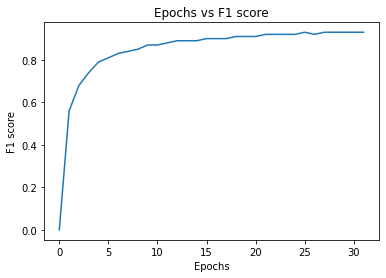

In [1]:
# importing the required module
import matplotlib.pyplot as plt
  
# x axis values
x = [i for i in range(32)]
# corresponding y axis values
y = [0.00, 0.56, 0.68, 0.74, 0.79, 0.81, 0.83, 0.84, 0.85, 0.87, 0.87, 0.88, 0.89, 0.89, 0.89, 0.90, 0.90, 0.90, 0.91, 0.91, 0.91, 0.92, 0.92, 0.92, 0.92, 0.93, 0.92, 0.93, 0.93, 0.93, 0.93, 0.93]

# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('F1 score')
  
# giving a title to my graph
plt.title('Epochs vs F1 score')
  
# function to show the plot
plt.show()